# Showcase CVX in Python by solving Max Cut

### Goal
Given a graph $G = (V,E) $, find a partition of the set of nodes $V$ into $S \cup \bar{S}$, such that the $\left| \left\{ [i,j], i \in S, j \in \bar{S} \right\} \right|$ is maximized.

![Max-Cut](Max-Cut.svg.png)

### Quadratic integer program
$ y_i = \begin{cases} 1 & \text{if } i \in S\\ -1 & \text{if } i \in \bar{S} \end{cases}$ for all $ i \in V$.

\begin{align*}
\max \quad &\sum_{[i,j] \in E} \frac{ 1 - y_i y_j }{2} \\
\text{s.t} \quad & y_i \in \{ -1, 1 \}
\end{align*}

Or equivalently
\begin{align*}
\max \quad &\sum_{[i,j] \in E} \frac{ 1 - y_i y_j }{2} \\
\text{s.t} \quad & y_i^2 = 1
\end{align*}

### SDP relaxation [Delorme & Poljac, '90 ]
Idea: Relax constraints $y_i^2 = 1$ by $ y_i \cdot y_i = 1$ for $y_i \in \mathbb{R}^n$.

That is,
\begin{align*}
\max \quad &\sum_{[i,j] \in E} \frac{ 1 - y_i \cdot y_j }{2} \\
\text{s.t} \quad & y_i \cdot y_i = 1\\
& y_i \in \mathbb{R}^n
\end{align*}

#### Why is this an SDP
Fact: If a matrix $A$ can be written as $ L L^{\top}$, then it is positive semi-definite.
Let $x_{ij} = y_i \cdot y_j$. That is $ X = \left[ \begin{array}{c} y_1 \\ \vdots \\  y_n \end{array} \right] \left[ \begin{array}{ccc} y_1 & \cdots & y_n \end{array} \right] = Y Y^{\top} $

Then we get,
\begin{align*}
\max \quad &\sum_{[i,j] \in E} \frac{ 1 - x_{ij} }{2} \\
\text{s.t} \quad & x_{ii} = 1\\
& X \succeq 0
\end{align*}


# Let's construct a graph

In [1]:
# import graph package
import networkx as nx
# Generate power law graph with 100 nodes and 5 edges from each new node
n = 50
G = nx.barabasi_albert_graph(n,5,2)

# get number of edges
m = G.number_of_edges()
# plot number of nodes & edges
print( 'Number of nodes: %d\nNumber of edges: %d' % ( n, m))

# get adjacency matrix
adjMatrix = nx.adjacency_matrix(G)

Number of nodes: 50
Number of edges: 225


In [12]:
import numpy as np

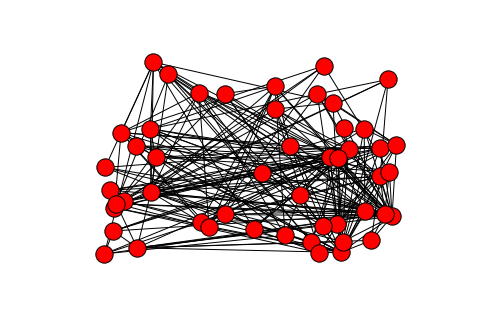

In [2]:
%matplotlib inline
# plot graph
nx.draw_random(G)

# Construct the SDP relaxation

In [8]:
# import all functions from cvx optimization package. See cvxpy.org for installation instructions
from cvxpy import *
import numpy as np

# Create positive semi-definite X matrix 
X = Semidef( n )

# set objective ( NOTE THAT IN PYTHON 2, division with integer values returns floored values)
# note that we divide by 4 instead of 2 since each edges is duplicated in the adjacency matrix
objective = Maximize( m / float( 2 ) - 1 / float( 4 ) * sum_entries( adjMatrix * X ))
    
# define ones vector for diagonal == 1
diagOne = Parameter( sign = "positive" )
diagOne.value = 1
constraints = [ diag( X ) == diagOne ]

# define problem
prob = Problem(objective, constraints)

# print optimal value
#print("Optimal value:", prob.solve(solver=CVXOPT))

In [16]:
# Find Y vectors
Y = np.linalg.cholesky( X.value)
# check that vectors are unit norm
np.linalg.norm(Y,axis=1)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

# Randomized Rounding (Goemans, Williams)
Since each vector $y_i$ is a vector with norm 1, it represents a direction in the $n$-dimensional unit ball. 

To find a feasible solution to the Max-Cut ploblem, the idea is as follows:  
* Draw a random vector $b$ form a rotational invariant distribution.
* Assign $\hat{y}_i = \begin{cases} 1 & \text{if } b^{\top} y_i \ge 0,\\
0 & \text{otherwise}. \end{cases} $.

This gives a feasible solution for the Max-Cut problem with $\mathbb{E}[\text{o.f.v.}] \ge 0.87856 OPT$, where $OPT$ is the optimal objective value.

In [189]:
# draw n-dimensional hyperplane from N(0,I_n).
hyperplane = np.random.normal( 0, 1, n )

# find yHat assignment
# dot( a, b ) determines the dot product
# dot( a, b ) >= 0 return true / false and int converts the result to 1/0
# [ func( Y[i, :] ) for i in range(n)] repeats the func for each row of Y and returns a vector with results
yHat = [ int( np.dot( hyperplane, np.transpose( Y[i,:] ) ) >= 0 ) for i in range( n )]
#print yHat

# find objective value
ofv = sum( [ 1 - yHat[i] * yHat[j] for (i,j) in G.edges() ])
print ofv

154


In [190]:
nIter= 1000;
ofvAll = np.zeros( nIter )
for k in range( nIter ):
    # draw n-dimensional hyperplane from N(0,I_n).
    hyperplane = np.random.normal( 0, 1, n )

    # find yHat assignment
    # dot( a, b ) determines the dot product
    # dot( a, b ) >= 0 return true / false and int converts the result to 1/0
    # [ func( Y[i, :] ) for i in range(n)] repeats the func for each row of Y and returns a vector with results
    yHat = [ int( np.dot( hyperplane, np.transpose( Y[i,:] ) ) >= 0 ) for i in range( n )]
    #print yHat

    # find objective value
    ofv = sum( [ 1 - yHat[i] * yHat[j] for (i,j) in G.edges() ])
    #print ofv
    ofvAll[k] = ofv

print( "Number of Iterations: %d\nMean objective value: %f\nStd objective value: %f" % (nIter,np.mean(ofvAll),np.std(ofvAll) ) )

Number of Iterations: 1000
Mean objective value: 175.179000
Std objective value: 23.530554


In [191]:
# get bound:
print np.mean( ofvAll ) / np.max( ofvAll )

0.862950738916
